In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os
from google.colab import files
from google.colab import drive


Mounted at /content/drive
Done


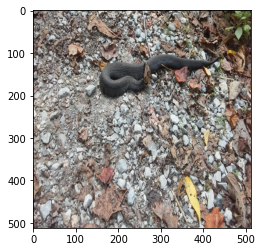

In [2]:
drive.mount('/content/drive')
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/15-classes.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

picture = plt.imread('/content/15-classes/train/20/0b103c4331bb47f4890d6e0ec96bf9bf.jpg')
imageShow = plt.imshow(picture)

In [3]:
mobilenetV2=models.mobilenet_v2(pretrained=False,num_classes=15)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(mobilenetV2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenetV2.to(device)
print("Device: {}".format(device))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mobilenetV2.parameters(), lr=0.0002,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)
n_epochs = 100
epoch_count = 0
# resnet18Model.load_state_dict(torch.load('/content/82-epoch-output.pt'))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Device: cuda:0


In [4]:

#import this file to train models and pass the  name of the datset
# extract zip files
# load the images and labels based on the dataset requested
# do the pre-processing , batch normalization , flip etc

# Transofrmations for preprocessedSnakeImages dataset
# Reference from https://www.youtube.com/watch?v=z3kB3ISIPAg&list=PL3Dh_99BJkCEhE7Ri8W6aijiEqm3ZoGRq&index=4
training_path = '/content/15-classes/train/'
test_path = '/content/15-classes/test'
val_path = '/content/15-classes/val'
def transformDS1( batchSize, inputSize):

    training_transforms = transforms.Compose([transforms.Resize((inputSize,inputSize)),transforms.ToTensor()])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
    train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batchSize,shuffle=False)
    mean, std = get_mean_std(train_Loader)
    train_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=test_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_path,transform=val_transforms)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)

    return train_loader,data_loader_test,val_loader

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

def show_transformed_images(train_loader):
    batch=next(iter(train_loader))
    images,labels = batch
    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()
    print("labels:",labels)


In [5]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

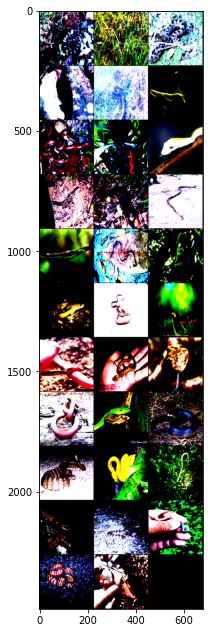

labels: tensor([ 3,  8,  1,  1,  8,  5,  2, 13,  6, 14,  4, 14,  5, 10,  6,  9, 10,  8,
         0, 12, 12,  0,  6,  8,  3, 13,  5, 13,  3,  0, 11, 10])


In [6]:
train_loader,test_loader,val_loader = transformDS1(32,224)
show_transformed_images(val_loader)

In [7]:

Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
total_steps = len(train_loader)
t1 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
validation_accuracy = 0
for epoch in range(n_epochs):
    print("Epoch number %d" %(epoch+1))
    mobilenetV2.train()
    running_loss = 0.0
    running_correct = 0.0
    val_loss = 0.0
    total = 0
    for i, data in enumerate(train_loader):
      images,labels = data
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      images = images.to(device)
      labels = labels.to(device)
      total+=labels.size(0)

      optimizer.zero_grad()
      outputs = mobilenetV2(images)
      _,predicted = torch.max(outputs.data,1)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      
      running_loss+=loss.item()
      running_correct += (labels==predicted).sum().item()
     
      
      training_accuracy = (running_correct / total) * 100
    validation_accuracy = 0
    mobilenetV2.eval()
    with torch.no_grad(): 
        val_correct = 0
        val_total = 0
        val_loss = 0
        for data in val_loader:
            images, val_labels = data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs = mobilenetV2(images)
            lossVal = criterion(outputs,val_labels)
            val_loss += lossVal.item()
            # Validation set accuracy
            
            _,predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == val_labels).sum().item()
            val_total  += val_labels.size(0)
          
        validation_accuracy = (val_correct / val_total) *100

    scheduler.step()  
    epoch_loss = running_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    epoch_accuracy = 100.00 * running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f"%(epoch_loss,epoch_accuracy,val_loss))

print("---Training finished in {} seconds---".format(time.time()-t1))
epoch_count+=n_epochs
torch.save(mobilenetV2.state_dict(), "/content/15-Class-"+str(epoch_count)+"-epoch.pt")

test_acc = evaluate_model(mobilenetV2,test_loader)
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
dictLoss = {'Training': trainLoss,'Validation': valLoss}
df = pd.DataFrame(dict)
df2 = pd.DataFrame(dictLoss)
df.to_csv("/content/Accuracies"+str(epoch_count)+".csv")
df2.to_csv("/content/Loss"+str(epoch_count)+".csv")
files.download("/content/15-Class-"+str(epoch_count)+"-epoch.pt")
files.download("/content/Accuracies"+str(epoch_count)+".csv")
files.download("/content/Loss"+str(epoch_count)+".csv")

Epoch number 1
Training Data: Epoch Loss: 2.714, Epoch Accuracy: 7.453, Validation Loss: 2.705
Epoch number 2
Training Data: Epoch Loss: 2.704, Epoch Accuracy: 7.143, Validation Loss: 2.702
Epoch number 3
Training Data: Epoch Loss: 2.699, Epoch Accuracy: 8.834, Validation Loss: 2.688
Epoch number 4
Training Data: Epoch Loss: 2.683, Epoch Accuracy: 11.180, Validation Loss: 2.670
Epoch number 5
Training Data: Epoch Loss: 2.655, Epoch Accuracy: 10.904, Validation Loss: 2.630
Epoch number 6
Training Data: Epoch Loss: 2.599, Epoch Accuracy: 12.698, Validation Loss: 2.568
Epoch number 7
Training Data: Epoch Loss: 2.552, Epoch Accuracy: 12.905, Validation Loss: 2.525
Epoch number 8
Training Data: Epoch Loss: 2.517, Epoch Accuracy: 13.630, Validation Loss: 2.482
Epoch number 9
Training Data: Epoch Loss: 2.481, Epoch Accuracy: 13.906, Validation Loss: 2.446
Epoch number 10
Training Data: Epoch Loss: 2.461, Epoch Accuracy: 14.700, Validation Loss: 2.427
Epoch number 11
Training Data: Epoch Loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
print(val_loss/len(val_loader))

0.1743441761032609


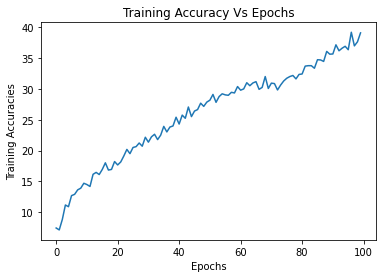

In [9]:
# Plotting Accuracies Vs Epochs
plt.plot(range(n_epochs),Accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.show()

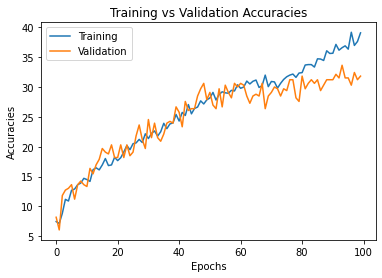

In [10]:
# Plotting Validation Accuracies Vs Train Accuracies on Epochs
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()

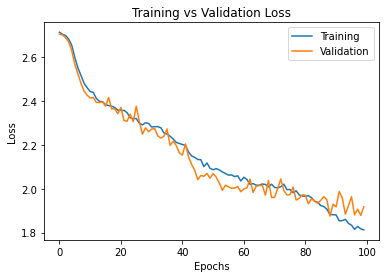

In [11]:
# Plotting Validation Accuracies Vs Train Accuracies on Epochs
plt.plot(range(n_epochs),trainLoss, label="Training")
plt.plot(range(n_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

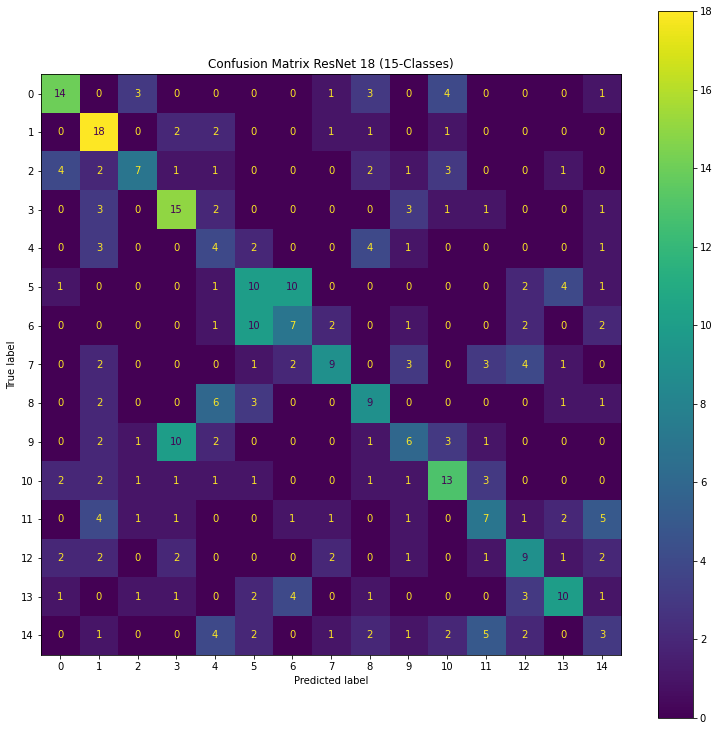

In [12]:
#Calculate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = mobilenetV2(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,14)

# Build confusion matrix
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix ResNet 18 (15-Classes)")
disp.plot(ax=ax)
plt.show()

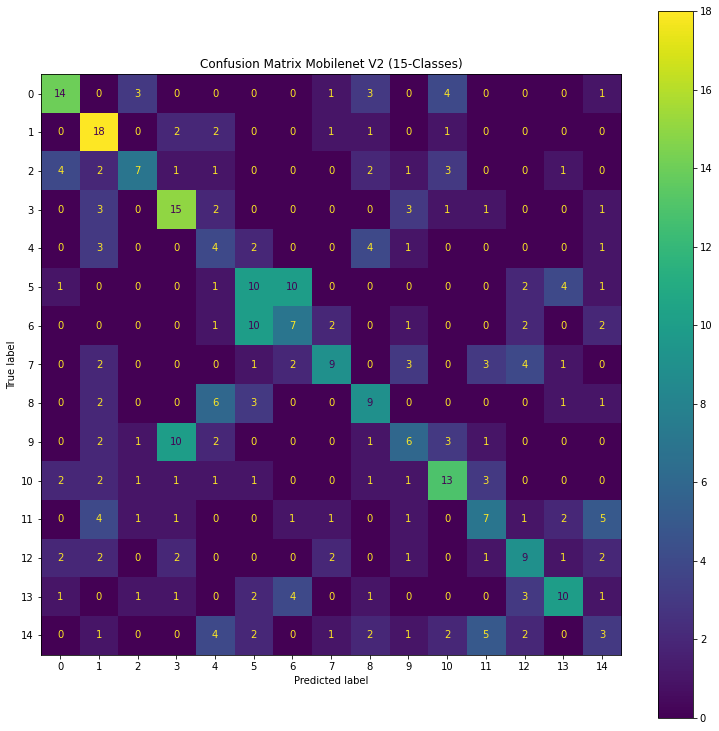

In [13]:
#Calculate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = mobilenetV2(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,14)

# Build confusion matrix
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix Mobilenet V2 (15-Classes)")
disp.plot(ax=ax)
plt.show()